## **Setting Up Fabric Integration (Tool) with Azure AI Agents**

> ⚠️ **Feature In Public Preview**  

### **📝 Overview**

Integrate your Azure AI Agent with Fabric `Data agent` to unlock powerful data analysis capabilities. Fabric `Data Agent` transforms enterprise data into conversational Q&A systems, allowing users to interact with data through chat and uncover actionable insights effortlessly.

When a user sends a query, the Azure AI Agent first determines if Fabric `Data agent` should be leveraged. If so, it uses the end user’s identity to generate queries over accessible data, and then returns responses based on the queried results. With **on-behalf-of (OBO) authorization**, this integration simplifies secure access to enterprise data in Fabric while ensuring robust protection and proper access control.

### **✅ Prerequisites**
- **Published Fabric AI Skill**: Ensure you have a published Fabric `Data Agent`. [See How-to Guide](https://learn.microsoft.com/en-us/fabric/data-science/how-to-create-data-agent)  
   > **Note:** You need a paid Fabric capacity (P SKU or higher).  
   - **Power BI Premium (P SKUs):** P1, P2, etc. (managed via Microsoft 365 EA)  
   - **Azure Fabric (F SKUs):** F2, F4, ... up to F2048 (purchased in the Azure portal)  
   - For general Fabric workloads, F2+ is sufficient. For AI Skills (formerly "Data Agent"), use F64 or above.
- **Permission/Role Assignment**:
  - **Access to AI Skill**: Users must have at least “Read” access to the `Data Agent` and connected data sources.
  - **RBAC for Foundry Project**: End users must have the `AI Developer` role assigned.

### **Step-by-Step Guide**

1. **Access the Agent Playground**:
   - Navigate to the Agent Playground in your Azure AI environment.

2. **Create or Use an Existing Agent**:
   - Either create a new agent or select an existing one to configure.

3. **Add a Knowledge Source**:
   - Click to add a knowledge source and select **Microsoft Fabric**.
   - If you don’t see this option, ensure the feature flag `&flight=MicrosoftFabricKnowledge` is enabled.

4. **Create a New Connection**:
   - Provide the following key-value pairs for the connection:
     - `workspace-id`: `xxx`
     - `artifact-id`: `xxx`
     - `audience`: `xxx`
   - These values can be found in your Data Agent endpoint. The endpoint format is:
     ```
     https://daily.powerbi.com/groups/<workspace_id>/aiskills/<artifact-id>
     ```

5. **Mark Fields as Secret**:
   - Check the “is secret” option for all fields to ensure secure handling of sensitive information.

6. **Name Your Connection**:
   - Assign a meaningful name to your connection for easy identification.

7. **Start Chatting with Fabric**:
   - Once the connection is set up, you can begin interacting with Fabric through your Azure AI Agent.

For more details and the latest guidance, see the [official Microsoft documentation on integrating Fabric tools with Azure AI Agents](https://learn.microsoft.com/en-us/azure/ai-services/agents/how-to/tools/fabric?pivots=portal).


In [1]:
import os

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Define the target directory
target_directory = os.getcwd()  # Get the current working directory

# Move one directory back
parent_directory = os.path.dirname(target_directory)

# Check if the parent directory exists
if os.path.exists(parent_directory):
    # Change the current working directory to the parent directory
    os.chdir(parent_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Parent directory {parent_directory} does not exist.")

Directory changed to c:\Users\pablosal\Desktop\gbb-ai-agenticrag


In [2]:
import importlib.metadata as md

# Versions - we are currently 1.0.0b9 of azure-ai-projects
print("semantic-kernel version:", md.version("semantic-kernel"))
print("azure-ai-projects version:", md.version("azure-ai-projects"))
# if you want to Upgrade the SDKs, uncomment the line below but code might break
# %pip install -U semantic-kernel azure-ai-projects azure-identity

semantic-kernel version: 1.28.1
azure-ai-projects version: 1.0.0b9


In [3]:
import os
import re
import time
import logging
import json
from datetime import datetime as pydatetime
from typing import Any, List, Dict, Optional
from dotenv import load_dotenv
import asyncio
from datetime import timedelta

# Azure AI Projects
from azure.identity.aio import DefaultAzureCredential
from azure.core.exceptions import HttpResponseError

# semantic kernel
from semantic_kernel.contents import AuthorRole
from semantic_kernel.agents.azure_ai.azure_ai_agent import (
    AzureAIAgent,
    AzureAIAgentSettings,
)
from semantic_kernel.agents.open_ai.run_polling_options import RunPollingOptions

# Load environment variables from .env file
load_dotenv()

# configure logging
from utils.ml_logging import get_logger

logger = get_logger()

In [4]:
import os
import json
import logging
from typing import Set, Tuple, Optional
from azure.core.exceptions import ServiceRequestError
from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient


def process_citations(text_msg) -> str:
    """
    Given a text_message with .text.value and .text.annotations, append a
    **Citations** section with unique URL citations.
    """
    base = text_msg.text.value
    seen: Set[Tuple[str, str]] = set()

    for annot in getattr(text_msg.text, "annotations", []):
        uc = getattr(annot, "url_citation", None)
        if uc and uc.url:
            seen.add((annot.text, uc.url))

    if seen:
        base += "\n\n**Citations:**\n"
        for quote, url in seen:
            base += f"- **Quote**: {quote}  \n"
            base += f"  **URL**: [{url}]({url})\n"

    return base


def run_agent(
    project_client: AIProjectClient, agent_id: str, user_input: str
) -> Tuple[str, str]:
    """
    • Posts `user_input` to a new thread on `agent_id`.
    • Blocks until the run completes.
    • Gathers only the *real* assistant replies, enriches with citations.
    Returns (conversation_text, thread_id).
    """
    # 1) create thread & send question
    thread = project_client.agents.create_thread()
    project_client.agents.create_message(
        thread_id=thread.id, role="user", content=user_input
    )

    # 2) run & wait
    project_client.agents.create_and_process_run(thread_id=thread.id, agent_id=agent_id)

    # 3) collect & enrich only true assistant messages
    convo = f"👤 User: {user_input}\n"
    pager = project_client.agents.list_messages(thread_id=thread.id)
    messages = pager.data if hasattr(pager, "data") else list(pager)

    for msg in messages:
        # only look at assistant turns
        if msg.role.lower() != "assistant":
            continue

        for text_msg in getattr(msg, "text_messages", []):
            content = text_msg.text.value.strip()

            # skip exact echoes of the prompt
            if content == user_input.strip():
                continue

            enriched = process_citations(text_msg)
            convo += f"\n🤖 Assistant: {enriched}\n"

    return convo, thread.id

### **Create Client and Load Azure AI Foundry**

Here, we initialize the Azure AI client using DefaultAzureCredential. This allows us to authenticate and connect to the Azure AI service.

In [5]:
project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.environ["AZURE_AI_FOUNDRY_CONNECTION_STRING"],
)

In [6]:
from azure.ai.projects.models import (
    FabricTool,
    ToolSet,
)


def get_connection_id(client: AIProjectClient, env_var: str) -> Optional[str]:
    """
    Retrieves the connection object using a connection name stored in an environment variable.

    Args:
        client: The Azure AI Project client.
        env_var (str): The environment variable holding the connection name.

    Returns:
        Connection object if found, otherwise raises an error.
    """
    connection_name = os.getenv(env_var)
    if not connection_name:
        logger.error(f"Missing environment variable: '{env_var}'")
        raise ValueError(f"Environment variable '{env_var}' is required.")

    try:
        connection = client.connections.get(connection_name=connection_name)
        logger.info(f"Retrieved Connection ID for {env_var}: {connection.id}")
        return connection
    except Exception as e:
        logger.error(f"Failed to retrieve connection for {env_var}: {e}")
        raise


# Initialize Azure AI Agent settings
dataretrievalagent_settings = AzureAIAgentSettings.create()

toolset = ToolSet()

try:
    # Retrieve and add Fabric Tool
    fabric_connection = get_connection_id(project_client, "TOOL_CONNECTION_NAME_FABRIC")
    toolset.add(FabricTool(connection_id=fabric_connection.id))

    logger.info("Successfully created ToolSet with SharePoint and Fabric tools.")
except Exception as e:
    logger.error(f"Failed to create ToolSet: {e}")
    raise

The create method is deprecated. Use the __new__ method instead.
2025-06-23 19:16:10,545 - micro - MainProcess - INFO     Retrieved Connection ID for TOOL_CONNECTION_NAME_FABRIC: /subscriptions/47f1c914-e299-4953-a99d-3e34644cfe1c/resourceGroups/rg-zhuoqunliai/providers/Microsoft.MachineLearningServices/workspaces/zhuoqunli-1959/connections/glucose_data_fabric (2578983275.py:get_connection_id:25)
2025-06-23 19:16:10,545 - micro - MainProcess - INFO     Successfully created ToolSet with SharePoint and Fabric tools. (2578983275.py:<module>:42)


In [8]:
dataretrievalagent_settings_definition = project_client.agents.create_agent(
    model=dataretrievalagent_settings.model_deployment_name,
    name="FabricDataRetrievalAgent",
    description=(
        "An AI agent specialized in retrieving and integrating structured data from Microsoft Fabric. "
        "This includes performance metrics, experiment results, and analytics data. "
        "The agent is designed to assist in research and development by providing accurate, relevant, and actionable data. "
        "If no relevant data is found, the agent must clearly indicate this and provide suggestions for alternative queries or data sources."
    ),
    instructions=(
        "### Role & Objective\n"
        "You are a research-focused AI assistant responsible for retrieving structured data exclusively from Microsoft Fabric. "
        "Your goal is to provide precise, well-referenced, and relevant responses to support research and development efforts.\n\n"
        "### Data Retrieval & Prioritization\n"
        "1. **Structured Data (Microsoft Fabric):** \n"
        "   - Retrieve data from Microsoft Fabric when the query involves numerical metrics, performance statistics, or structured analytics.\n"
        "   - Data is available to support comparisons of the accuracy and reliability of two glucose monitoring products (Product A and Product B). "
        "This structured data evaluates performance across different glucose ranges and includes MARD percentages, accuracy within ±20 mg/dL/±20%, and the number of readings for each product.\n"
        "   - Example: clinical glucose monitoring studies between Product A or Product B.\n\n"
        "2. **Integrated Queries:** \n"
        "   - If the query requires multiple structured metrics, retrieve and integrate the results for a comprehensive response.\n"
        "   - Ensure clarity in presenting combined insights.\n\n"
        "3. **Fallback Behavior:** \n"
        "   - If no relevant data is found in Microsoft Fabric, respond with:\n"
        "     - A clear statement that no relevant data was found.\n"
        "     - Suggestions for alternative queries or data sources (if applicable).\n"
        "     - Example: 'No relevant data was found for the requested query in Microsoft Fabric. Consider refining your query or exploring other data sources.'\n\n"
        "### Response Quality\n"
        "1. **Accuracy & Relevance:** Always prioritize retrieving the most current and applicable data from Microsoft Fabric.\n"
        "2. **Clarity & Transparency:** Clearly indicate the data source(s) used and any limitations in the available information.\n"
        "3. **Fallback Handling:** If no relevant data is found, provide a professional and helpful fallback response as outlined above.\n"
        "4. **Professionalism:** Present findings in a structured and concise manner to facilitate decision-making.\n"
    ),
    toolset=toolset,
    headers={"x-ms-enable-preview": "true"},
    temperature=0.7,
    top_p=1,
    metadata={
        "use_case": "Structured Data Retrieval for R&D",
        "data_source": "Microsoft Fabric (structured metrics only)",
    },
)

# Print the agent's run ID (agent ID)
print(f"DataRetrievalAgent Run ID: {dataretrievalagent_settings_definition.id}")

DataRetrievalAgent Run ID: asst_yGjKW4o5OXBZIML4qxdVmdoW


In [9]:
user_query = "In which glucose ranges does Product A underperform compared to Product B, and what clinical impact could this have?"
fabric_response, threadID = run_agent(
    project_client, "asst_iyRaKRHpkLsWBByZJR80b5KC", user_query
)

In [10]:
print(fabric_response)

👤 User: In which glucose ranges does Product A underperform compared to Product B, and what clinical impact could this have?

🤖 Assistant: Product A underperforms compared to Product B in several glucose ranges, as evidenced by the Mean Absolute Relative Difference (MARD) and accuracy within ±20 mg/dL/±20%. Below is the performance comparison:

### Mean Absolute Relative Difference (MARD) Percentage:
- **181 to 250 mg/dL:** Product A: 11.2%, Product B: 7.5%
- **54 to 69 mg/dL:** Product A: 13.5%, Product B: 9.3%
- **70 to 180 mg/dL:** Product A: 11.9%, Product B: 7.9%
- **< 54 mg/dL:** Product A: 16.3%, Product B: 12.2%
- **< 70 mg/dL:** Product A: 14.1%, Product B: 9.8%
- **> 250 mg/dL:** Product A: 10.8%, Product B: 7%

### Accuracy Within ±20 mg/dL/±20%:
- **181 to 250 mg/dL:** Product A: 81.3%, Product B: 93.1%
- **54 to 69 mg/dL:** Product A: 68.7%, Product B: 85.4%
- **70 to 180 mg/dL:** Product A: 76.5%, Product B: 90.5%
- **< 54 mg/dL:** Product A: 60.8%, Product B: 78.1%
- **<

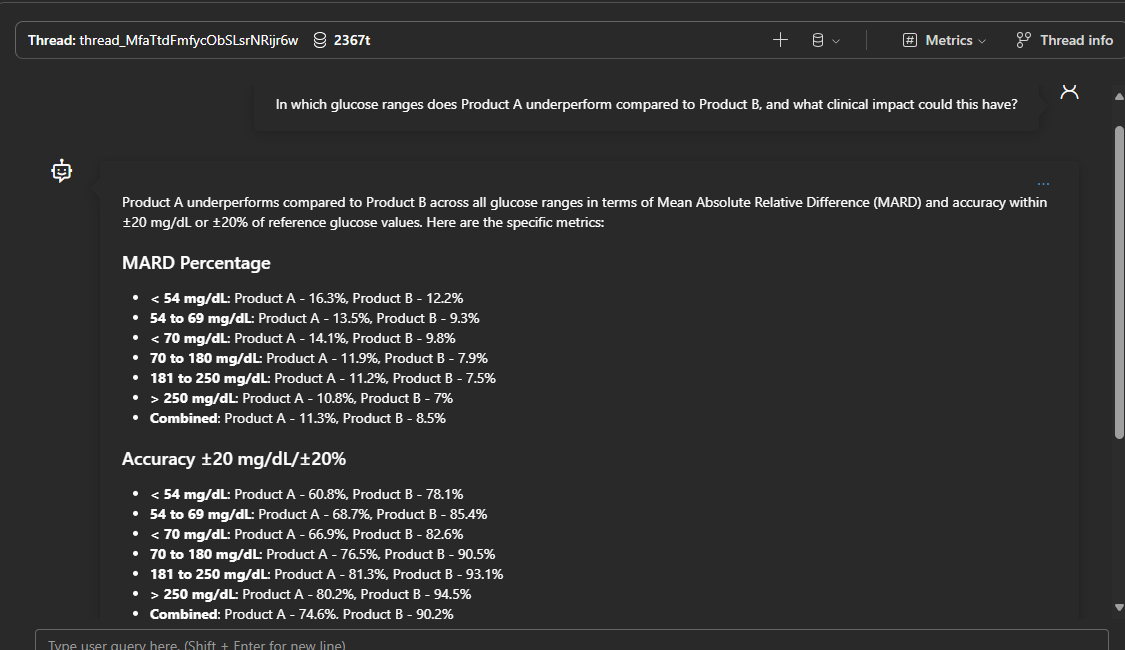

We were able to query the right information from our Lakehouse in Fabric !!

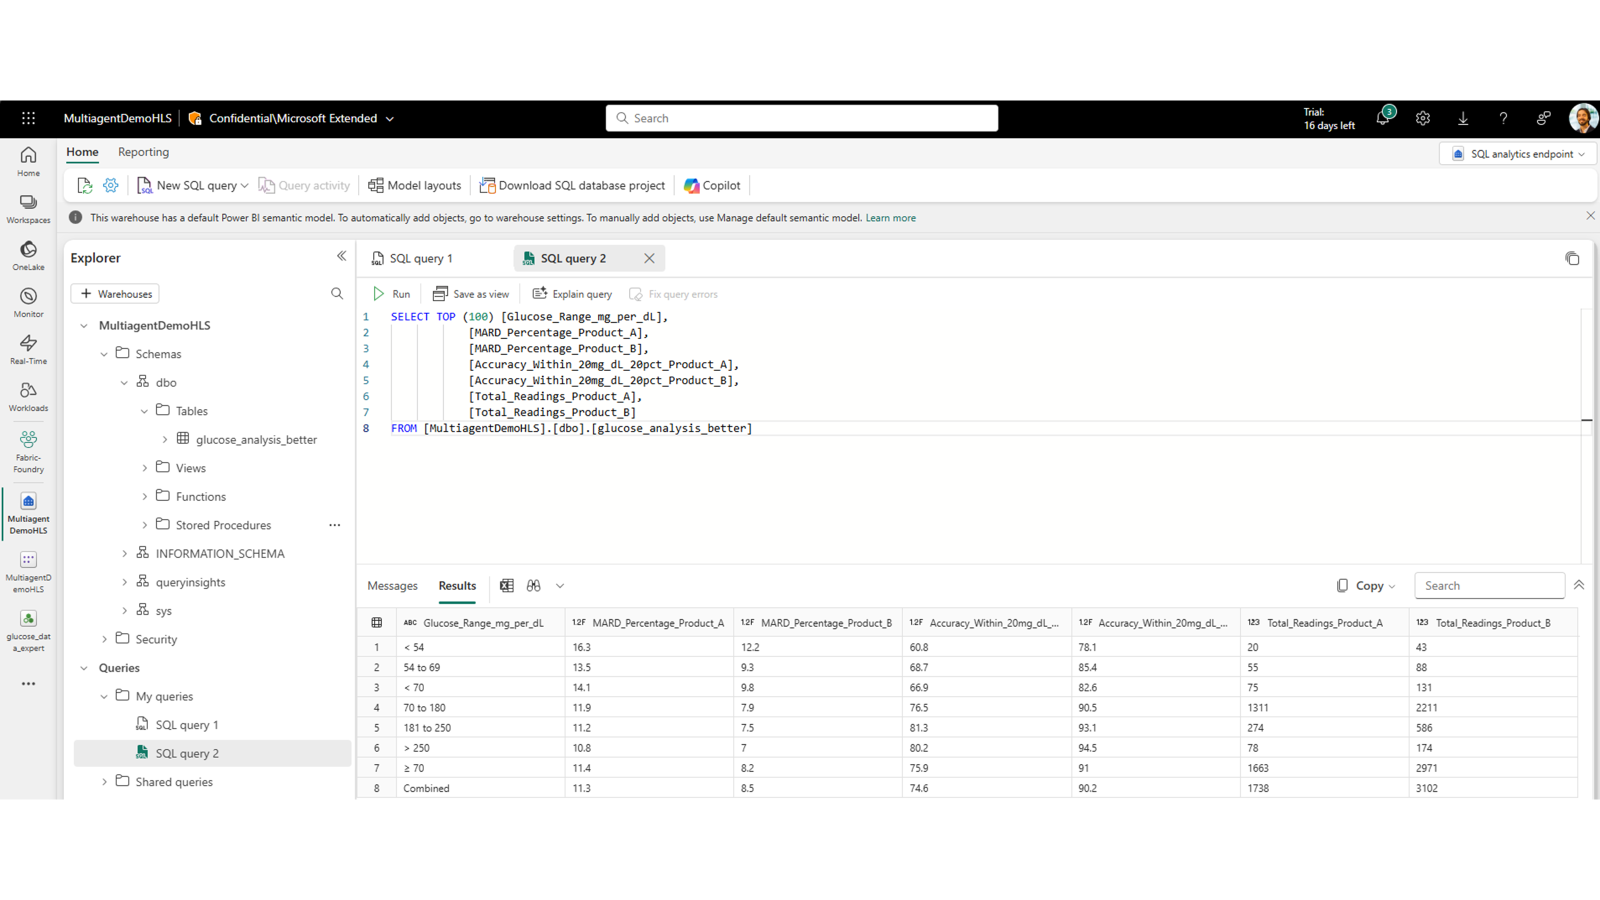